In [64]:
import numpy as np
import urllib
import matplotlib.pyplot as plt
import sklearn
import scipy.optimize
import random
from collections import defaultdict
import nltk
import string
from nltk.stem.porter import *
from sklearn import linear_model
import pandas as pd
import os
import operator as op
from collections import Counter
import scipy as sp
import ast
import pickle
from wordcloud import WordCloud
os.chdir("E:\\CSE 258\Homework\\Assignment2")

In [10]:
# df = pd.read_csv("Merged_fke_gdn.csv", converters = {1:ast.literal_eval}) # Injection caused crashing, so we revert to failsafe
df = pd.read_csv("Merged_fke_gdn_nyt.csv")
df.text = df.text.apply(ast.literal_eval)
df = df.sample(frac = 1).reset_index()

In [ ]:
# Convert all strings to lowercase tokens
# for i, doc in enumerate(df.text):
    
#     df.text[i] = [c.lower() for c in doc]
#     if i%500 == 0:
#         print("{}th article smallified".format(i))

c:\users\haseeb\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0th article smallified
500th article smallified
1000th article smallified
1500th article smallified
2000th article smallified
2500th article smallified
3000th article smallified


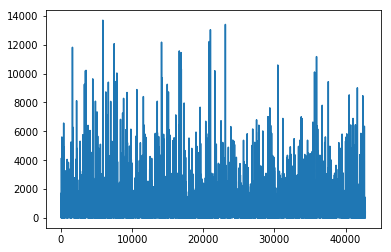

In [3]:
lengths = []
for d in df.text:
    lengths.append(len(d))
x = range(len(lengths))
plt.plot(x, lengths)
plt.show()

In [11]:
df = df[['text', 'class']]

In [12]:
# Obtain word dictionary
wordCount = defaultdict(int)

for d in df.text:
    
    for w in d:
        
        wordCount[w] += 1

print("Number of unique words: {}".format(len(wordCount)))

Number of unique words: 420327


In [54]:
pickle_out = open("dict.unigrams","wb")
pickle.dump(wordCount, pickle_out)
pickle_out.close()

In [13]:
words = [(wordCount[w], w) for w in wordCount]
words.sort()
words.reverse()
# Selecting 1000 most popular words for tf-idf generation
words = [x[1] for x in words[:1000]]

In [86]:
# Generating TF-IDF
wordId = dict(zip(words, range(len(words))))
idf_dict = defaultdict(float)

def feature(datum):
    
    feat = [0]*len(words)
    r = datum
    
    for w in r:
        
        if w in words:
            
            feat[wordId[w]] += 1
            
    return feat

X = np.array([feature(d) for d in df.text])
print("Shape of X = {}".format(X.shape))
X_idf = X > 0

X_idf = np.sum(X_idf, axis = 0)
X_idf = len(df.text)*1.0/X_idf
X_idf = np.log10(X_idf)
print("Shape of X_idf = {}".format(X_idf.shape))
# X_tfidf = np.array([np.multiply(x, X_idf) for x in X])

Shape of X = (42780, 1000)
Shape of X_idf = (1000,)


In [87]:
pickle_out = open("1000_pop_words_IDF","wb")
pickle.dump(X_idf, pickle_out)
pickle_out.close()

In [88]:
X = X.astype(float)

In [89]:
for i in range(len(X)):
    
    X[i] = np.multiply(X[i], X_idf)

In [90]:
y = df['class']
X = np.array([np.append(x, 1.0) for x in X])

prop_train = 0.7
prop_valid = 0.2
ntrain = np.int(prop_train * len(X))
nvalid = ntrain + np.int(prop_valid * len(X))

X_train = X[0:ntrain]
X_valid = X[ntrain:nvalid]
X_test = X[nvalid:]

y_train = y[0:ntrain]
y_valid = y[ntrain:nvalid]
y_test = y[nvalid:]

#With regularization
clf = linear_model.LogisticRegression()
clf.fit(X_train, y_train)
predictions = clf.predict(X_valid) > 0.5

tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_valid, predictions).ravel()

In [91]:
print("Accuracy = {}".format((tn + tp)*1.0/(tn + tp + fn + fp)))
print("True negative = {}".format(tn))
print("True positive = {}".format(tp))
print("False negative = {}".format(fn))
print("False positive = {}".format(fp))

Accuracy = 0.9696119682094436
True negative = 5979
True positive = 2317
False negative = 86
False positive = 174


In [103]:
theta = clf.coef_[0][0:-1]
word_weights = []

for i, t in enumerate(theta):
    
    word_weights.append((t, words[i]))

word_weights.sort()

In [107]:
type(word_weights[2][1])

str

In [124]:
pos_words = defaultdict(int)
neg_words = defaultdict(int)

for w in word_weights:
    
    if w[0] > 0:
        if len(w[1]) > 3:
            pos_words[w[1]] = np.int(w[0]*100)

    if w[0] < 0:
        if len(w[1]) > 3:
            neg_words[w[1]] = np.int(w[0]*-100)

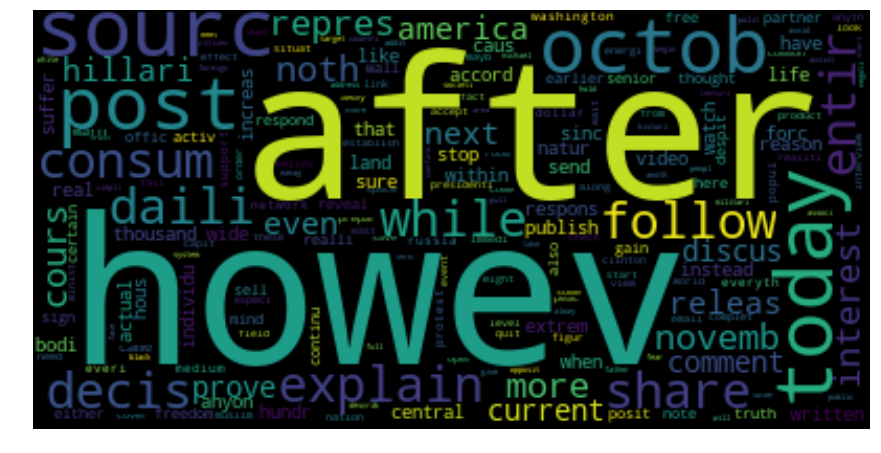

In [141]:
from pylab import rcParams
pos_wc = WordCloud()
wc.generate_from_frequencies(pos_words)
rcParams['figure.figsize'] = 15, 15
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

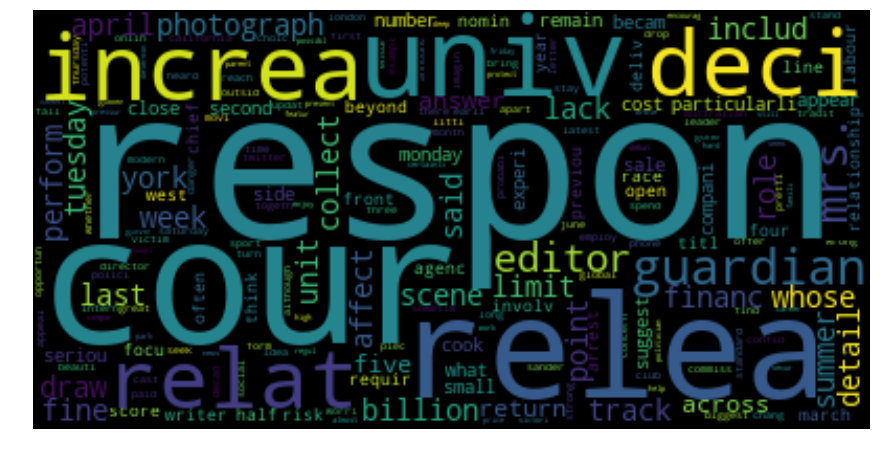

In [142]:
from pylab import rcParams
pos_wc = WordCloud()
wc.generate_from_frequencies(neg_words)
rcParams['figure.figsize'] = 15, 15
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()